# ResOpsAUS: stations
***

***Author:** Chus Casado Rodríguez*<br>
***Date:** 18-03-2025*<br>



In [258]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import Point
from shapely.geometry import box
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

In [2]:
from lisfloodreservoirs.utils.utils import filter_reservoirs, remove_duplicates
from lisfloodreservoirs.utils import DatasetConfig

## Configuration

In [3]:
cfg = DatasetConfig('config_dataset.yml')

print(f'Attributes will be saved in {cfg.PATH_ATTRS}')

# extent of Australia
extent = box(110, -46, 156, -10) # minx, miny, maxx, maxy

Attributes will be saved in Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsAU\v1.0\attributes


In [ ]:
# with open('config_dataset.yml', 'r', encoding='utf8') as ymlfile:
#     cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

# VERSION = cfg['version']

# URL = cfg['url']

# PATH_DATASET = Path(cfg['paths']['ResOps']['root'])

# # conditions to consider a reservoir in the ResOpsES dataset
# MIN_AREA = cfg['conditions'].get('min_area', None) # km2
# MIN_VOL = cfg['conditions'].get('min_volume', None) # hm3

# # path where results will be saved
# PATH_ATTR = PATH_DATASET / 'raw' / 'attributes'
# PATH_ATTR.mkdir(parents=True, exist_ok=True)
# print(f'Attributes will be saved in {PATH_ATTR}')
# PATH_TS = PATH_DATASET/ 'raw' / 'time_series'
# PATH_TS.mkdir(parents=True, exist_ok=True)
# print(f'Time series will be saved in {PATH_TS}')

In [ ]:
# PATH_GRAND = Path(cfg['paths']['GRanD'])

In [ ]:
# PATH_DATASET = Path('Z:/nahaUsers/casadje/datasets/reservoirs/ResOpsAU')
# PATH_OUT = PATH_DATASET / 'GIS'
# PATH_OUT.mkdir(parents=True, exist_ok=True)

## BOM
### Stations
#### Volume

In [225]:
# stations reporting volume
stations_vol = pd.read_csv(cfg.PATH_RESOPS / 'raw' / 'attributes' / 'stations_volume.csv')
rename_cols = {
    'station_name': 'name',
    'station_no': 'number',
    'station_number': 'number',
    'station_id': 'id',
    'station_latitude': 'latitude',
    'station_longitude': 'longitude'
}
stations_vol.rename(columns=rename_cols, inplace=True, errors='ignore')
stations_vol.name = stations_vol.name.str.lower()
stations_vol.set_index('number', drop=True, inplace=True)
stations_vol[['latitude', 'longitude']] = stations_vol[['latitude', 'longitude']].astype(float)
stations_vol['volume'] = True

# remove stations without coordinates
missing_coords = stations_vol.latitude.isnull() | stations_vol.longitude.isnull()
print('{0} stations are missing coordinates'.format(missing_coords.sum()))
stations_vol = stations_vol[~missing_coords]

# remove stations without time series
missing_ts = [no for no in set(stations_vol.index) if (cfg.PATH_OBS_TS / f'{no}_volume.csv').is_file() is False]
print('{0} stations are missing the time series'.format(len(missing_ts)))
stations_vol.drop(missing_ts, axis=0, inplace=True)

# # remove stations with wrong coordinates
stations_vol = gpd.GeoDataFrame(
    stations_vol,
    geometry=[Point(xy) for xy in zip(stations_vol.longitude, stations_vol.latitude)],
    crs='epsg:4326'
)
mask_extent = stations_vol.geometry.within(extent)
print('{0} stations have wrong coordinates'.format((~mask_extent).sum()))
stations_vol = stations_vol[mask_extent]

print('{0} stations contain meta data'.format(len(stations_vol)))
print('{0} stations contain volume data'.format(len(set(stations_vol.index))))

10 stations are missing coordinates
30 stations are missing the time series
15 stations have wrong coordinates
566 stations contain meta data
525 stations contain volume data


#### Level

In [236]:
# stations reporting level
stations_lev = pd.read_csv(cfg.PATH_RESOPS / 'raw' / 'attributes' / 'stations_level.csv')
stations_lev.rename(columns=rename_cols, inplace=True, errors='ignore')
stations_lev.name = stations_lev.name.str.lower()
stations_lev.set_index('number', drop=True, inplace=True)
stations_lev[['latitude', 'longitude']] = stations_lev[['latitude', 'longitude']].astype(float)
stations_lev['level'] = True

# remove stations without coordinates
missing_coords = stations_lev.latitude.isnull() | stations_lev.longitude.isnull()
print('{0} stations are missing coordinates'.format(missing_coords.sum()))
stations_lev = stations_lev[~missing_coords]

# remove stations without time series
missing_ts = [no for no in set(stations_lev.index) if (cfg.PATH_OBS_TS / f'{no}_level.csv').is_file() is False]
print('{0} stations are missing the time series'.format(len(missing_ts)))
stations_lev.drop(missing_ts, axis=0, inplace=True)

# remove stations with wrong coordinates
stations_lev = gpd.GeoDataFrame(
    stations_lev,
    geometry=[Point(xy) for xy in zip(stations_lev.longitude, stations_lev.latitude)],
    crs='epsg:4326'
)
mask_extent = stations_lev.geometry.within(extent)
print('{0} stations have wrong coordinates'.format((~mask_extent).sum()))
stations_lev = stations_lev[mask_extent]

print('{0} stations contain meta data'.format(len(stations_lev)))
print('{0} stations contain level data'.format(len(set(stations_lev.index))))

12 stations are missing coordinates
50 stations are missing the time series
15 stations have wrong coordinates
597 stations contain meta data
556 stations contain level data


### Processing

In [241]:
# intersection and difference between the two sets of stations
ids_int = stations_vol.index.intersection(stations_lev.index)
ids_diff = stations_lev.index.difference(stations_vol.index)

# update 'level' attribute in 'stations_vol'
stations_vol['level'] = False
stations_vol.loc[ids_int, 'level'] = True

# update 'volume' attribute in 'stations_lev'
stations_lev['volume'] = False
stations_lev.loc[ids_int, 'volume'] = True

# concatenate both sets
stations = pd.concat((stations_vol, stations_lev.loc[ids_diff, :]), axis=0)
print('{0} stations contain either metadata'.format(len(stations)))
print('{0} stations contain either volume or level data'.format(len(set(stations.index))))

664 stations contain either metadata
623 stations contain either volume or level data


In [243]:
stations.head()

,name,id,latitude,longitude,volume,geometry,level
number,,,,,,,
PI_357693.1,"10 mile brook dam water level daily value, sou...",3572876,-33.963617,115.124899,True,POINT (115.12490 -33.96362),True
408216A,amphitheatre res. hg,2705644,-37.173235,143.377498,True,POINT (143.37750 -37.17324),True
418.1,arthurs lake - at pump station,3162458,-41.988306,146.862472,True,POINT (146.86247 -41.98831),True
155.1,augusta lake - at intake,3162361,-41.844444,146.572222,True,POINT (146.57222 -41.84444),True
212211,avon dam,16372090,-34.350932,150.640500,True,POINT (150.64050 -34.35093),True


In [292]:
def remove_duplicates(
    df: pd.DataFrame,
    duplicates_col: str,
    select_col: str,
    ascending: bool = False,
) -> pd.DataFrame:
    """Given a DataFrame, it identifies duplicate entries in a column and selects that with the largest value in another column

    Parameters:
    -----------
    df: pd.DataFrame
        table from which duplicates will be removed
    duplicates_col: string
        column in "df" where duplicated values will be identified
    select_col: string
        column in "df" used to select one entry from the duplicates. For each duplicated value in "duplicated_col", the largest (ascending=False) or smallest (ascending=True) value in "select_col" will be kept
    ascending: boolean
        whether to sort the 'select_col' in ascending (True) or descending (False) order
        
    Returns:
    --------
    A DataFrame similar to the input, but with duplicates removed
    """
    
    df_ = df.copy()
    
    for value, count in df_[duplicates_col].value_counts().items():
        if count > 1:
            remove_idx = df_.loc[df_[duplicates_col] == value].sort_values(select_col, ascending=ascending).index[1:]
            df_.drop(remove_idx, axis=0, inplace=True)
        else:
            break
            
    return df_

In [249]:
# remove duplicated station number
stations_ = remove_duplicates(stations.reset_index(), duplicates_col='number', select_col='id', ascending=True).set_index('number')

<AxesSubplot:>

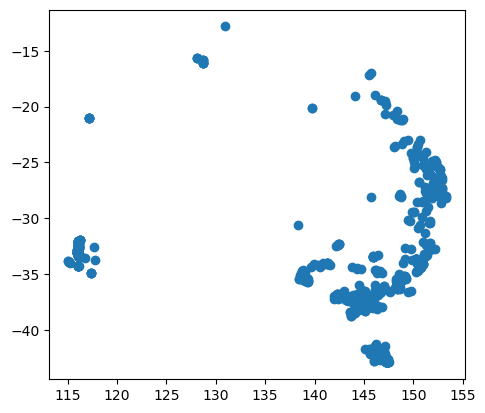

In [250]:
stations_.plot()

In [11]:
# # convert to geopandas
# stations = gpd.GeoDataFrame(
#     data=stations,
#     geometry=[Point(xy) for xy in zip(stations.longitude, stations.latitude)],
#     crs='epsg:4326'
# )

721 stations contain either volume or level data


In [253]:
stations.loc['122010A']

,name,id,latitude,longitude,volume,geometry,level
number,,,,,,,
122010A,peter faust dam,113137,-20.366710,148.382200,True,POINT (148.38220 -20.36671),True
122010A,peter faust dam hw,3242359,-20.366806,148.382306,True,POINT (148.38231 -20.36681),True


In [254]:
stations_.loc['122010A']

name                    peter faust dam
id                               113137
latitude                      -20.36671
longitude                      148.3822
volume                             True
geometry     POINT (148.3822 -20.36671)
level                              True
Name: 122010A, dtype: object

In [ ]:
# # rename columns
# stations.rename(columns={'station_number': 'number', 'station_name': 'name'}, inplace=True)
# stations.index.name = 'number'

In [298]:
stations_grand = gpd.read_file(cfg.PATH_RESOPS / 'GIS' / 'stations+GRanD.shp'.format(datetime.now().strftime('%Y%m%d')))
stations_grand = stations_grand[stations_grand.GRAND_ID.notnull()]
stations_grand = remove_duplicates(stations_grand, duplicates_col='number', select_col='id', ascending=True)
stations_grand.set_index('number', drop=True, inplace=True)
stations_grand.GRAND_ID = stations_grand.GRAND_ID.astype(int)
stations_grand.shape

(228, 8)

In [299]:
no_int = stations_.index.intersection(stations_grand.index)
len(no_int)

224

In [303]:
stations_.loc[no_int, 'GRAND_ID'] = stations_grand.loc[no_int, 'GRAND_ID']
stations_.GRAND_ID = stations_.GRAND_ID.astype('Int64')

In [304]:
stations_.head()

,name,id,latitude,longitude,volume,geometry,level,GRAND_ID
number,,,,,,,,
PI_357693.1,"10 mile brook dam water level daily value, sou...",3572876,-33.963617,115.124899,True,POINT (115.12490 -33.96362),True,<NA>
408216A,amphitheatre res. hg,2705644,-37.173235,143.377498,True,POINT (143.37750 -37.17324),True,<NA>
418.1,arthurs lake - at pump station,3162458,-41.988306,146.862472,True,POINT (146.86247 -41.98831),True,<NA>
155.1,augusta lake - at intake,3162361,-41.844444,146.572222,True,POINT (146.57222 -41.84444),True,<NA>
212211,avon dam,16372090,-34.350932,150.640500,True,POINT (150.64050 -34.35093),True,6750


<AxesSubplot:>

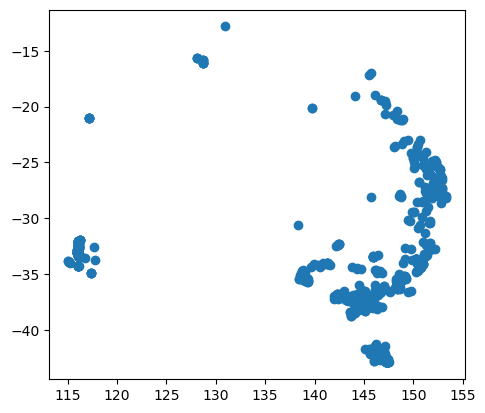

In [305]:
stations_.plot()

In [307]:
stations_.GRAND_ID.notnull().sum()

224

In [309]:
len(stations_.GRAND_ID.unique())

148

In [306]:
# export
stations_.to_file(cfg.PATH_RESOPS / 'GIS' / 'stations_{0}.shp'.format(datetime.now().strftime('%Y%m%d')))
stations_.to_csv(cfg.PATH_RESOPS / 'raw' / 'attributes' / 'stations_{0}.csv'.format(datetime.now().strftime('%Y%m%d')))

I found in QGIS the `GRAND_ID` associated with each point.

In [325]:
# load stations with GRAND_ID
stations_sel = gpd.read_file(cfg.PATH_RESOPS / 'GIS' / 'stations_{0}.shp'.format(datetime.now().strftime('%Y%m%d'))).set_index('number')
stations_sel = stations_sel[stations_sel.GRAND_ID.notnull()]
stations_sel.GRAND_ID = stations_sel.GRAND_ID.astype(int)

stations_sel.shape, len(stations_sel.GRAND_ID.unique())

((249, 8), 158)

## GRanD

In [321]:
# load shapefile of dams
grand = gpd.read_file(cfg.PATH_GRAND / 'GRanD_dams_v1_3.shp')
grand.set_index('GRAND_ID', drop=False, inplace=True)

# filter dams in Spain
grand = grand.loc[grand.COUNTRY == 'Australia']

# correct names
grand.DAM_NAME = grand.DAM_NAME.str.upper()
grand.RES_NAME = grand.RES_NAME.str.upper()
grand.ADMIN_UNIT = grand.ADMIN_UNIT.str.upper()

# rename columns
grand['LON'] = grand.geometry.x
grand['LAT'] = grand.geometry.y

print('GRanD')
print('-----')
print('No. reservoirs:\t{0}\nNo. attributes:\t{1}\n'.format(*grand.shape))

GRanD
-----
No. reservoirs:	190
No. attributes:	61



In [322]:
grand.index.difference(stations_sel.GRAND_ID)

Int64Index([5832, 6200, 6580, 6584, 6587, 6589, 6590, 6591, 6596, 6597, 6598,
            6601, 6602, 6609, 6636, 6645, 6662, 6672, 6674, 6676, 6677, 6690,
            6691, 6696, 6710, 6711, 6718, 6722, 6725, 6727, 6730, 6886],
           dtype='int64', name='GRAND_ID')

104 out of 190 reservoirs exceed the minimum catchment area of 250 km2 (0 missing values)
184 out of 190 reservoirs exceed the minimum reservoir volume of 10 hm3 (0 missing values)
101 out of 190 reservoirs exceed the minimum catchment area (250 km2) and the minimum reservoir volume (10 hm3)


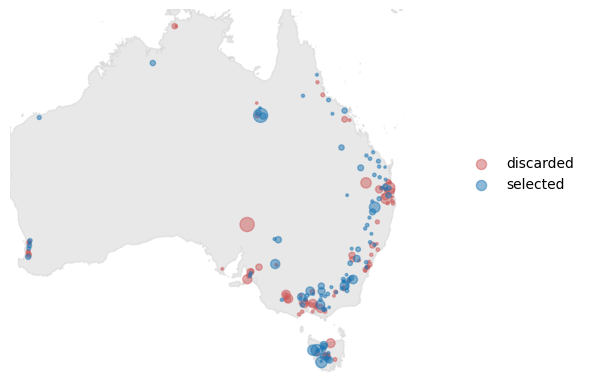

In [48]:
# select reservoirs based on catchment area and reservoir volume
mask_grand = filter_reservoirs(grand.CATCH_SKM, grand.CAP_MCM, cfg.MIN_AREA, cfg.MIN_VOL)

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
grand.loc[~mask_grand].plot(markersize=grand.CAP_MCM**.5, c='indianred', alpha=.5, ax=ax, label='discarded')
grand.loc[mask_grand].plot(markersize=grand.CAP_MCM**.5, alpha=.5, ax=ax, label='selected')
fig.legend(frameon=False, bbox_to_anchor=[1, .4, .1, .2])
ax.axis('off');

# apply the selection
# grand = grand.loc[mask_grand]

***

### Time series

In [326]:
stations_sel.GRAND_ID.isnull().sum()

0

In [327]:
stations_sel.head()

,name,id,latitude,longitude,volume,level,GRAND_ID,geometry
number,,,,,,,,
212211,avon dam,16372090,-34.350932,150.640500,1,1,6750,POINT (150.64050 -34.35093)
ODSS_18337_WSLAHD.1,argyle vill top dam wsl,3561132,-16.113575,128.732855,1,1,6201,POINT (128.73286 -16.11358)
212211.6,avon,3082493,-34.419586,150.675933,1,0,6750,POINT (150.67593 -34.41959)
212211.1,avon,3082486,-34.419586,150.675933,1,1,6750,POINT (150.67593 -34.41959)
212211.3,avon,3082489,-34.419586,150.675933,1,1,6750,POINT (150.67593 -34.41959)


In [329]:
for grand_id in stations_sel.GRAND_ID.unique():
    subset = stations_sel[stations_sel.GRAND_ID == grand_id]
    break

In [330]:
    subset

,name,id,latitude,longitude,volume,level,GRAND_ID,geometry
number,,,,,,,,
212211,avon dam,16372090,-34.350932,150.640500,1,1,6750,POINT (150.64050 -34.35093)
212211.6,avon,3082493,-34.419586,150.675933,1,0,6750,POINT (150.67593 -34.41959)
212211.1,avon,3082486,-34.419586,150.675933,1,1,6750,POINT (150.67593 -34.41959)
212211.3,avon,3082489,-34.419586,150.675933,1,1,6750,POINT (150.67593 -34.41959)


In [400]:
    timeseries = {}
    for no in subset.index:
        ts = []    
        for var in ['volume', 'level']:
            file = cfg.PATH_OBS_TS / f'{no}_{var}.csv'
            if file.is_file():
                ts_var = pd.read_csv(file, usecols=['Timestamp', 'Value'], index_col='Timestamp').squeeze()
                ts_var.name = var
                ts_var.index = pd.to_datetime(ts_var.index)
                start, end = ts_var.first_valid_index(), ts_var.last_valid_index()
                ts_var = ts_var[start:end]
                ts.append(ts_var)

        if len(ts) > 0:
            timeseries[no] = pd.concat(ts, axis=1)

In [371]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 8))
for ax, var in zip(axes, ['volume', 'level']):
    for no, ts in timeseries.items():
        if var in ts.columns:
            ax.plot(ts[var], label=no)
    ax.legend(frameon=False)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000014F916E1EE0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000014F916E1AF0> (for post_execute):


KeyboardInterrupt: 

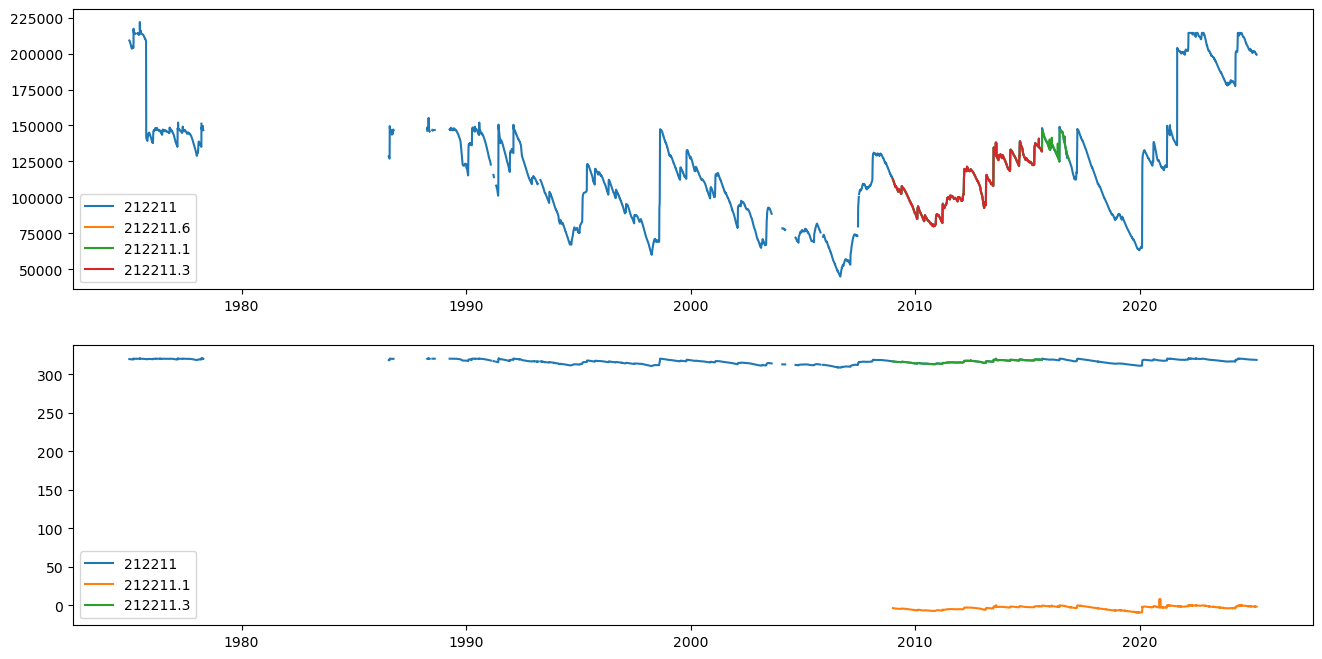

In [410]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 8))

for ax, var in zip(axes, ['volume', 'level']):
    i = 0
    for no, ts in timeseries.items():
        if var in ts.columns:
            ax.plot(ts[var], c=f'C{i}', label=no)
            i +=1
    ax.legend();

In [407]:
timeseries['212211.6'].notnull()

volume    0
dtype: int64

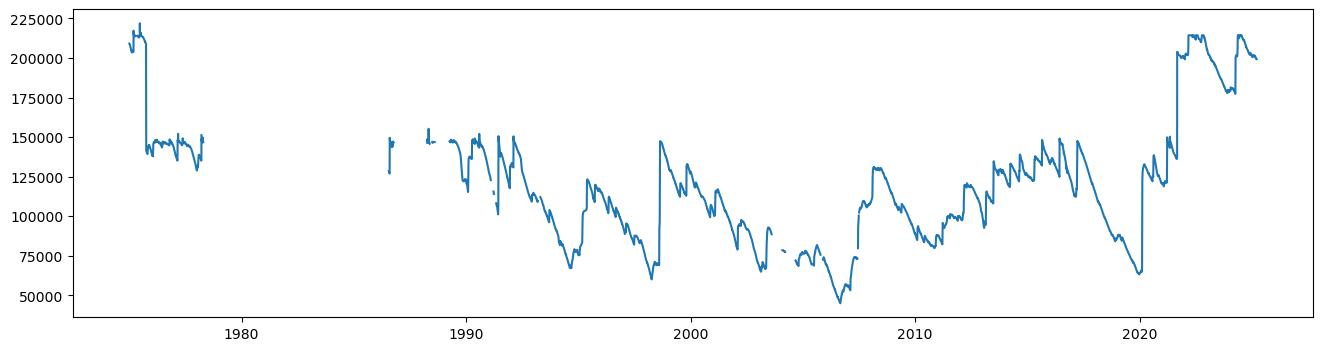

In [408]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(timeseries['212211'].volume);

In [383]:
timeseries[no].shape

(2426, 2)

In [389]:
pd.to_datetime(start), end

(Timestamp('2009-01-03 00:00:00'), '2015-08-25')

In [384]:
idx = pd.date_range(start, end, freq='q')

In [385]:
len(idx)

26

In [382]:
ts_var.shape

(2426,)

In [344]:
ts_var['Quality Code'].value_counts()

 90     13693
-1       4460
 140      139
 110       46
Name: Quality Code, dtype: int64